In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [90]:
class PerformancePlotter:
    def __init__(self, path):
        self.path = path
        self.dataframes = self.read_anotation_file()

    def read_anotation_file(self):
        path = self.path
        files = os.listdir(path)
        txt_files = [file for file in files if file.endswith('.txt')]
        dataframes = {}
        # print("#####################################")
        for file in txt_files:
            # read file
            file_name = file.split('_annotations.txt')[0]
            file_path = os.path.join(path, file)
            df = pd.read_csv(file_path, sep='\t', header=None, names=['beats', 'downbeats', 'beats_type'])
            
            # get the time signature from first row, third column
            info = df.iloc[0, 2]
            split_parts = info.split(',')
            df.iloc[0, 2] = split_parts[0]
            # print("The time signature is: ", split_parts[1])
            num_b = int(split_parts[1].split('/')[0])
            
            # convert the beats type to binary
            # df['beats_type'] = df['beats_type'].map({'db': 1, 'b': 0})
            df['duration'] = df['beats'].diff()
            df['duration'].iloc[0] = df['beats'].iloc[0]
            df.drop('downbeats', axis=1, inplace=True)
            
            # add the time signature and key signature to the column name
            if file_name == 'midi_score':
                column_name = 'Unperformed'
                df['duration'].iloc[0] = 1
                df.loc[0, 'duration'] = 1
                # print("The time signature is: ", split_parts[1])
                self.time_signature = split_parts[1]
            else:
                column_name = file_name + '_' + split_parts[1]
                
            df['num_bar'] = (df.index // num_b) + 1
            df['num_beat'] = (df.index % num_b) + 1
            # print(column_name)
            
            # Add the dataframe to the dictionary
            dataframes[column_name] = df
        # print("Finished reading txt files")
        # print("The total number of performed pieces is: ", len(dataframes) - 1)
        for key in dataframes:
            dataframes[key]['ratio'] = dataframes[key]['duration'] / dataframes['Unperformed']['duration']
        return dataframes

    def plot_ratio(self):
        print("#####################################")
        print("Plotting the ratio of the whole piece")
        for key in self.dataframes:
            plt.plot(self.dataframes[key]['ratio'], label=key)
        plt.xlabel('time')
        plt.ylabel('ratio')
        plt.legend()
        plt.show()
    
    def calculate_mean_onebar(self):
        means = {}
        for key in self.dataframes:
            means[key] = self.dataframes[key].groupby('num_beat')['ratio'].mean()
        means = pd.DataFrame(means)
        performed = [col for col in means.columns if col != 'Unperformed']
        means['average'] = means[performed].mean(axis=1)
        return means
    
    def calculate_mean(self, df):
        mean_data = {}
        mean_data['average'] = df.groupby('num_beat')['ratio'].mean()
        mean_df = pd.DataFrame(mean_data)
        performed = [col for col in mean_df.columns if col != 'Unperformed']
        mean_df['average'] = mean_df[performed].mean(axis=1)
        return mean_df
    
    def three_segment(self):
        total_bars = self.dataframes['Unperformed']['num_bar'].max()
        begin_end_index = total_bars // 3
        middle_end_index = begin_end_index * 2
        results = {}
        for key in self.dataframes:
            df = self.dataframes[key]
            begin = df[df['num_bar'] <= begin_end_index]
            middle = df[(df['num_bar'] > begin_end_index) & (df['num_bar'] <= middle_end_index)]
            end = df[df['num_bar'] > middle_end_index]

            begin_mean = self.calculate_mean(begin)
            middle_mean = self.calculate_mean(middle)
            end_mean = self.calculate_mean(end)

            result = pd.concat([begin_mean, middle_mean, end_mean], axis=0)
            results[key] = result
        mean_df = pd.concat(results.values(), keys=results.keys(), axis=1)
        mean_df.reset_index(inplace=True)
        mean_df.index += 1
        mean_df = mean_df.droplevel(1, axis=1)
        mean_df.drop('num_beat', axis=1, inplace=True)
        performed = [col for col in mean_df.columns if col != 'Unperformed']
        mean_df['average'] = mean_df[performed].mean(axis=1)
        return mean_df

    def plot_bar(self, means):
        for key in means:
            plt.plot(means[key], label=key)
        plt.xlabel('beat')
        plt.ylabel('ratio')
        plt.legend()
        xticks = means.index
        plt.xticks(xticks)
        plt.show()

    def plot_one_bar(self):
        self.plot_ratio()
        means = self.calculate_mean_onebar()
        print("#####################################")
        print("Plotting the timing mapping of one bar")
        self.plot_bar(means)

    def plot_three_segment(self):     
        means = self.three_segment()
        print("#####################################")
        print("Plotting the timing mapping of the piece in 3 segments")
        self.plot_bar(means)


#####################################
Plotting the ratio of the whole piece


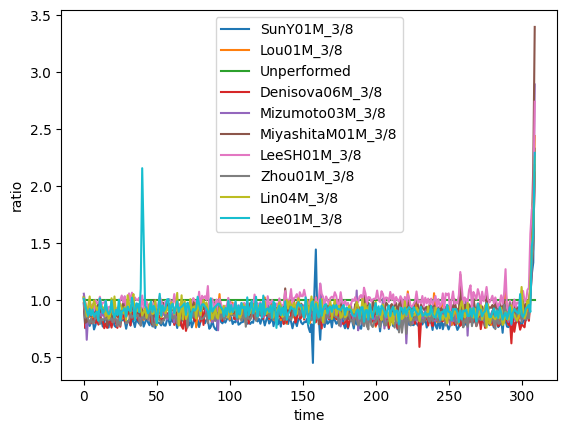

#####################################
Plotting the timing mapping of one bar


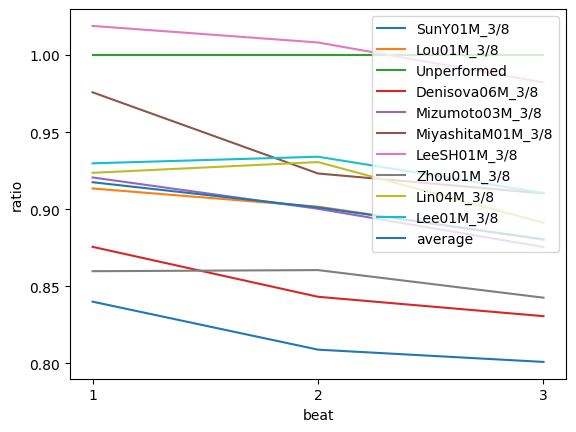

#####################################
Plotting the timing mapping of the piece in 3 segments


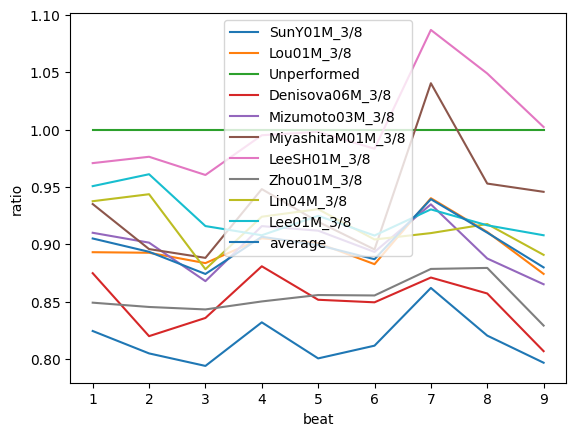

In [107]:
plotter = PerformancePlotter('./Bach/Prelude/bwv_848')
plotter.plot_one_bar()
plotter.plot_three_segment()

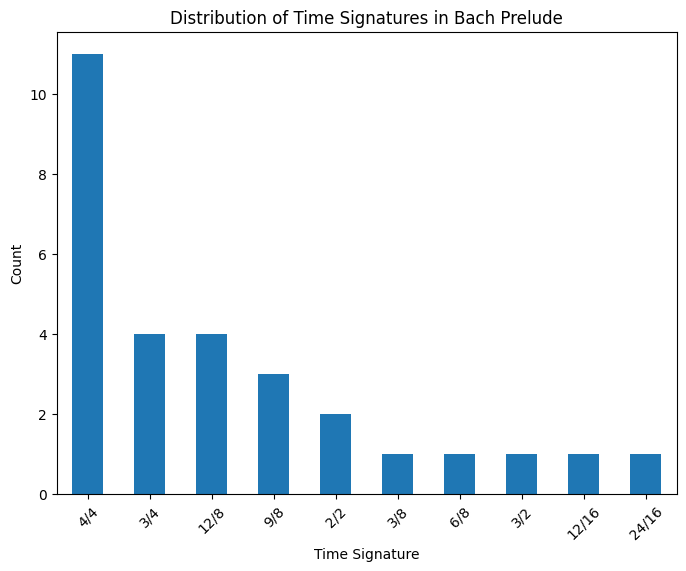

In [139]:
path = './Bach/Prelude'
time_signature = []
for folder in os.listdir(path):
    plotter = PerformancePlotter(os.path.join(path, folder))
    time_signature.append(plotter.time_signature)
time_signature = pd.Series(time_signature)
time_signature_counts = time_signature.value_counts()

plt.figure(figsize=(8, 6))
time_signature_counts.plot(kind='bar')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.title('Distribution of Time Signatures in Bach Prelude')
plt.xticks(rotation=45)
plt.show()


## Plot timing function for different time signature

In [183]:
def calculate_onebar_overall(path):
    grouped_means = {}
    for folder in os.listdir(path):
        plotter = PerformancePlotter(os.path.join(path, folder))
        key = plotter.time_signature
        if key not in grouped_means:
            grouped_means[key] = []
        means = plotter.calculate_mean_onebar()
        grouped_means[key].append(means['average'])

    group_averages = {}
    for key, value in grouped_means.items():
        group_averages[key] = pd.concat(value, axis=1).mean(axis=1)

    return group_averages

def plot_onebar_overall(path):
    group_averages = calculate_onebar_overall(path)
    for key, value in group_averages.items():
        plt.plot(value, label=key)
    plt.xlabel('beat')
    plt.ylabel('average ratio')
    plt.legend()
    plt.show()

In [184]:
def calculate_threeseg_overall(path):
    grouped_means = {}
    for folder in os.listdir(path):
        plotter = PerformancePlotter(os.path.join(path, folder))
        key = plotter.time_signature
        if key not in grouped_means:
            grouped_means[key] = []

        means = plotter.three_segment()
        grouped_means[key].append(means['average'])
    # grouped_means = {key: value for key, value in grouped_means.items() if len(value) >= 4}
    group_averages = {}
    for key, value in grouped_means.items():
        group_averages[key] = pd.concat(value, axis=1).mean(axis=1)

    return group_averages

def plot_threeseg_overall(path):
    group_averages = calculate_threeseg_overall(path)
    for key, value in group_averages.items():
        plt.plot(value, label=key)
    plt.xlabel('beat')
    plt.ylabel('average ratio')
    plt.legend()
    plt.show()


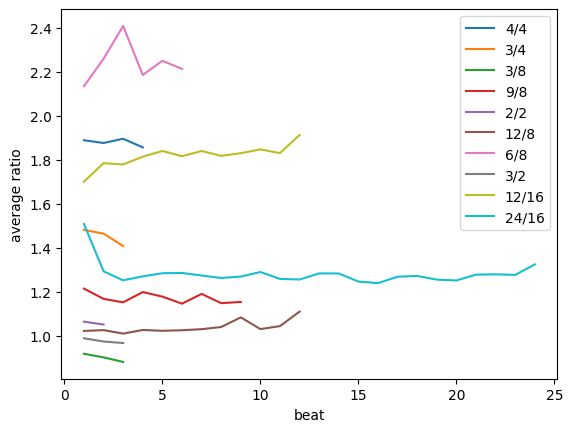

In [186]:
path = './Bach/Prelude'
plot_onebar_overall(path)

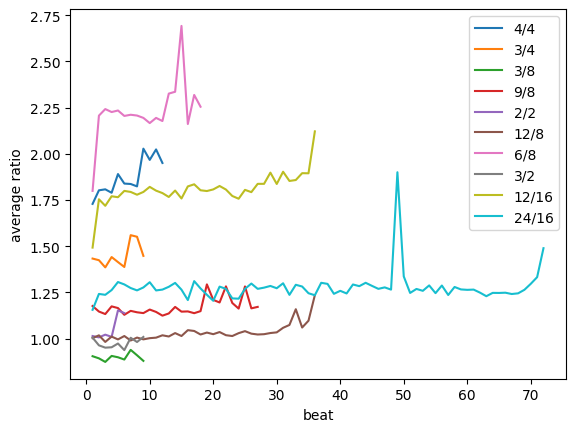

In [185]:
path = './Bach/Prelude'
plot_threeseg_overall(path)

In [208]:
def calculate_group_means(path):
    grouped_means = {}
    for folder in os.listdir(path):
        plotter = PerformancePlotter(os.path.join(path, folder))
        key = plotter.time_signature
        if key not in grouped_means:
            grouped_means[key] = []
        means = plotter.calculate_mean_onebar()
        grouped_means[key].append(means['average'])

    grouped_means = {key: value for key, value in grouped_means.items() if len(value) >= 3}
    
    group_averages = {}
    for key, value in grouped_means.items():
        group_averages[key] = pd.concat(value, axis=1).mean(axis=1)

    return group_averages

def plot_group_means(path):
    group_averages = calculate_group_means(path)
    print("Plotting the grouped means")

    total_keys = len(group_averages)
    total_rows = (total_keys + 2) // 2
    
    fig, axs = plt.subplots(total_rows, 2, figsize=(15, total_rows * 6))
    fig.subplots_adjust(hspace=0.5)
    
    row_index = 0
    col_index = 0
    for key, value in group_averages.items():
        ax = axs[row_index, col_index]
        ax.plot(value, label=key)
        ax.set_xlabel('beat')
        ax.set_ylabel('average ratio')
        ax.set_title(f'Average Ratio for Time Signature {key}')
        ax.legend()
        ax.set_ylim(1.0, 2.0)
        
        col_index += 1
        if col_index == 2:
            col_index = 0
            row_index += 1
    
    plt.show()

In [210]:
def three_segment_group_means(path):
    grouped_means = {}
    for folder in os.listdir(path):
        plotter = PerformancePlotter(os.path.join(path, folder))
        key = plotter.time_signature
        if key not in grouped_means:
            grouped_means[key] = []

        means = plotter.three_segment()
        grouped_means[key].append(means['average'])
    grouped_means = {key: value for key, value in grouped_means.items() if len(value) >= 3}
    
    group_averages = {}
    for key, value in grouped_means.items():
        group_averages[key] = pd.concat(value, axis=1).mean(axis=1)

    return group_averages

def plot_three_segment_group_means(path):
    group_averages = three_segment_group_means(path)
    print("Plotting the grouped means of three segments")

    total_keys = len(group_averages)
    total_rows = (total_keys + 2) // 2
    
    fig, axs = plt.subplots(total_rows, 2, figsize=(15, total_rows * 6))
    fig.subplots_adjust(hspace=0.5)
    
    row_index = 0
    col_index = 0
    for key, value in group_averages.items():
        ax = axs[row_index, col_index]
        ax.plot(value, label=key)
        ax.set_xlabel('beat')
        ax.set_ylabel('average ratio')
        ax.set_title(f'Average Ratio for Time Signature {key}')
        
        total_beats = len(value)
        begin_end_index = total_beats // 3
        middle_end_index = begin_end_index * 2
        
        ax.axvline(x=begin_end_index, color='r', linestyle='--')
        ax.axvline(x=middle_end_index, color='r', linestyle='--')
        # ax.set_ylim(1.0, 2.2)
        col_index += 1
        if col_index == 2:
            col_index = 0
            row_index += 1

### To have a closer look of those time signature with enough pieces

Plotting the grouped means


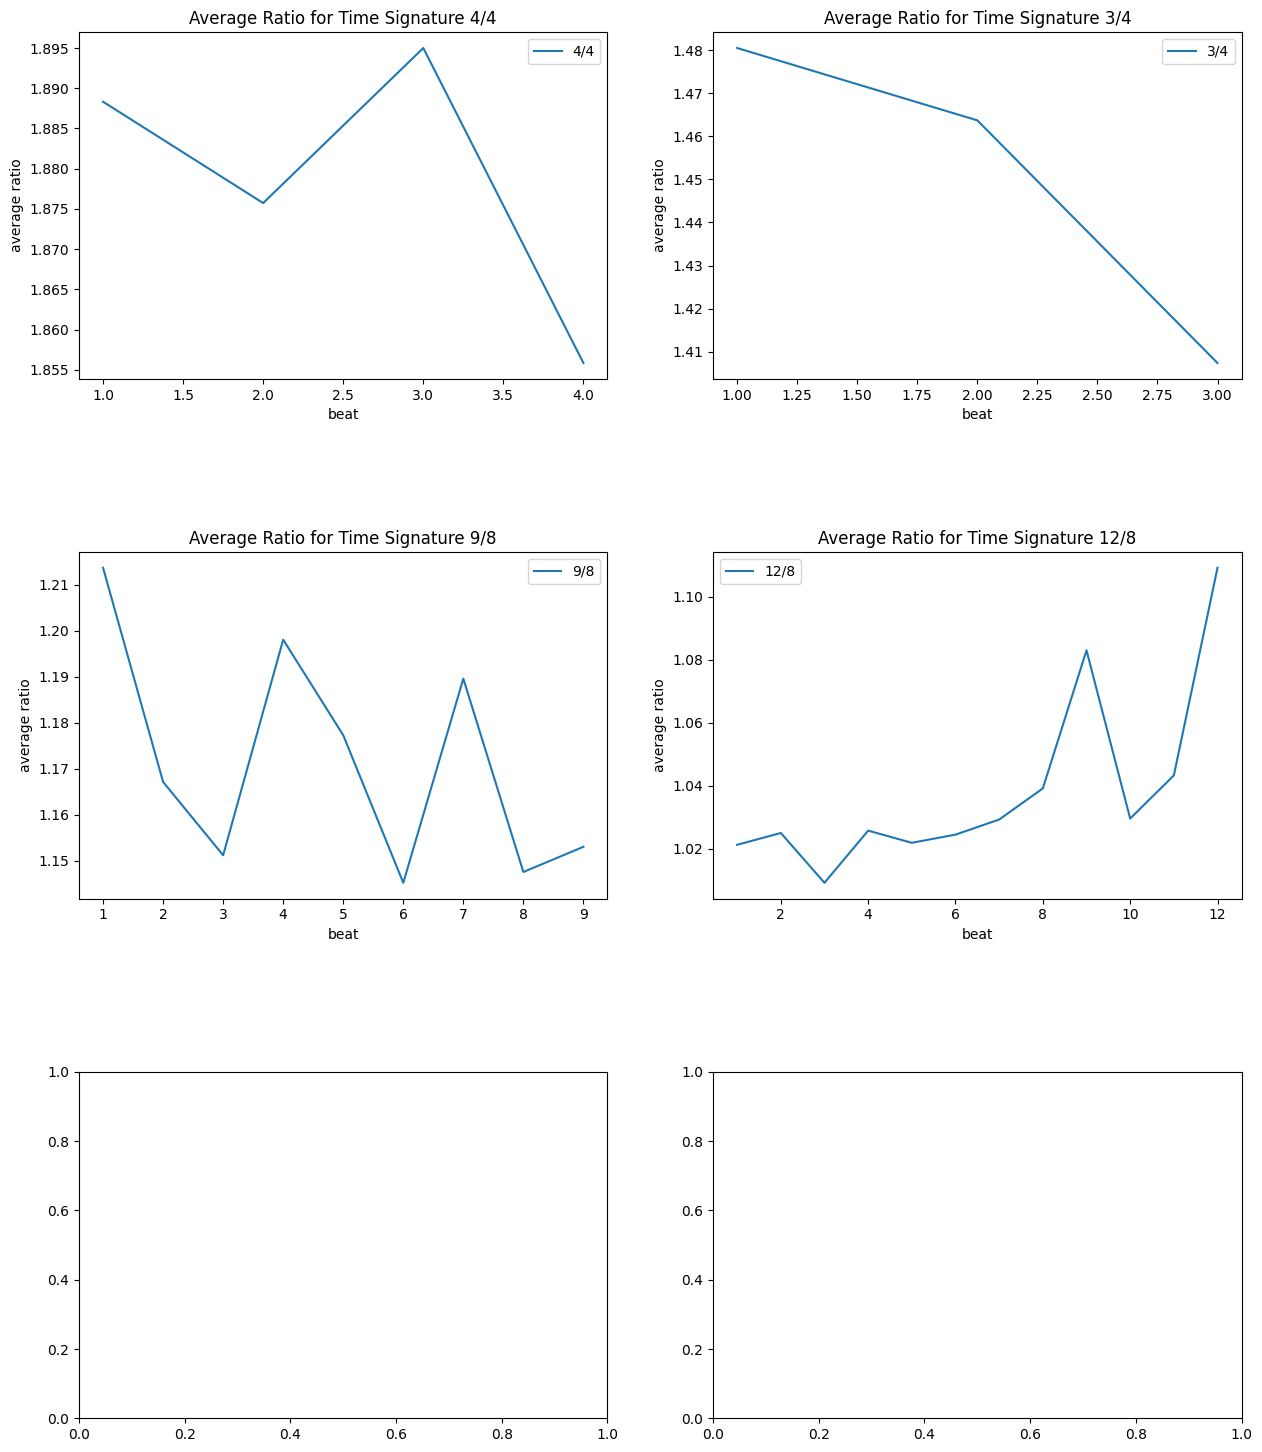

In [207]:
# y is not limited
plot_group_means(path)

Plotting the grouped means


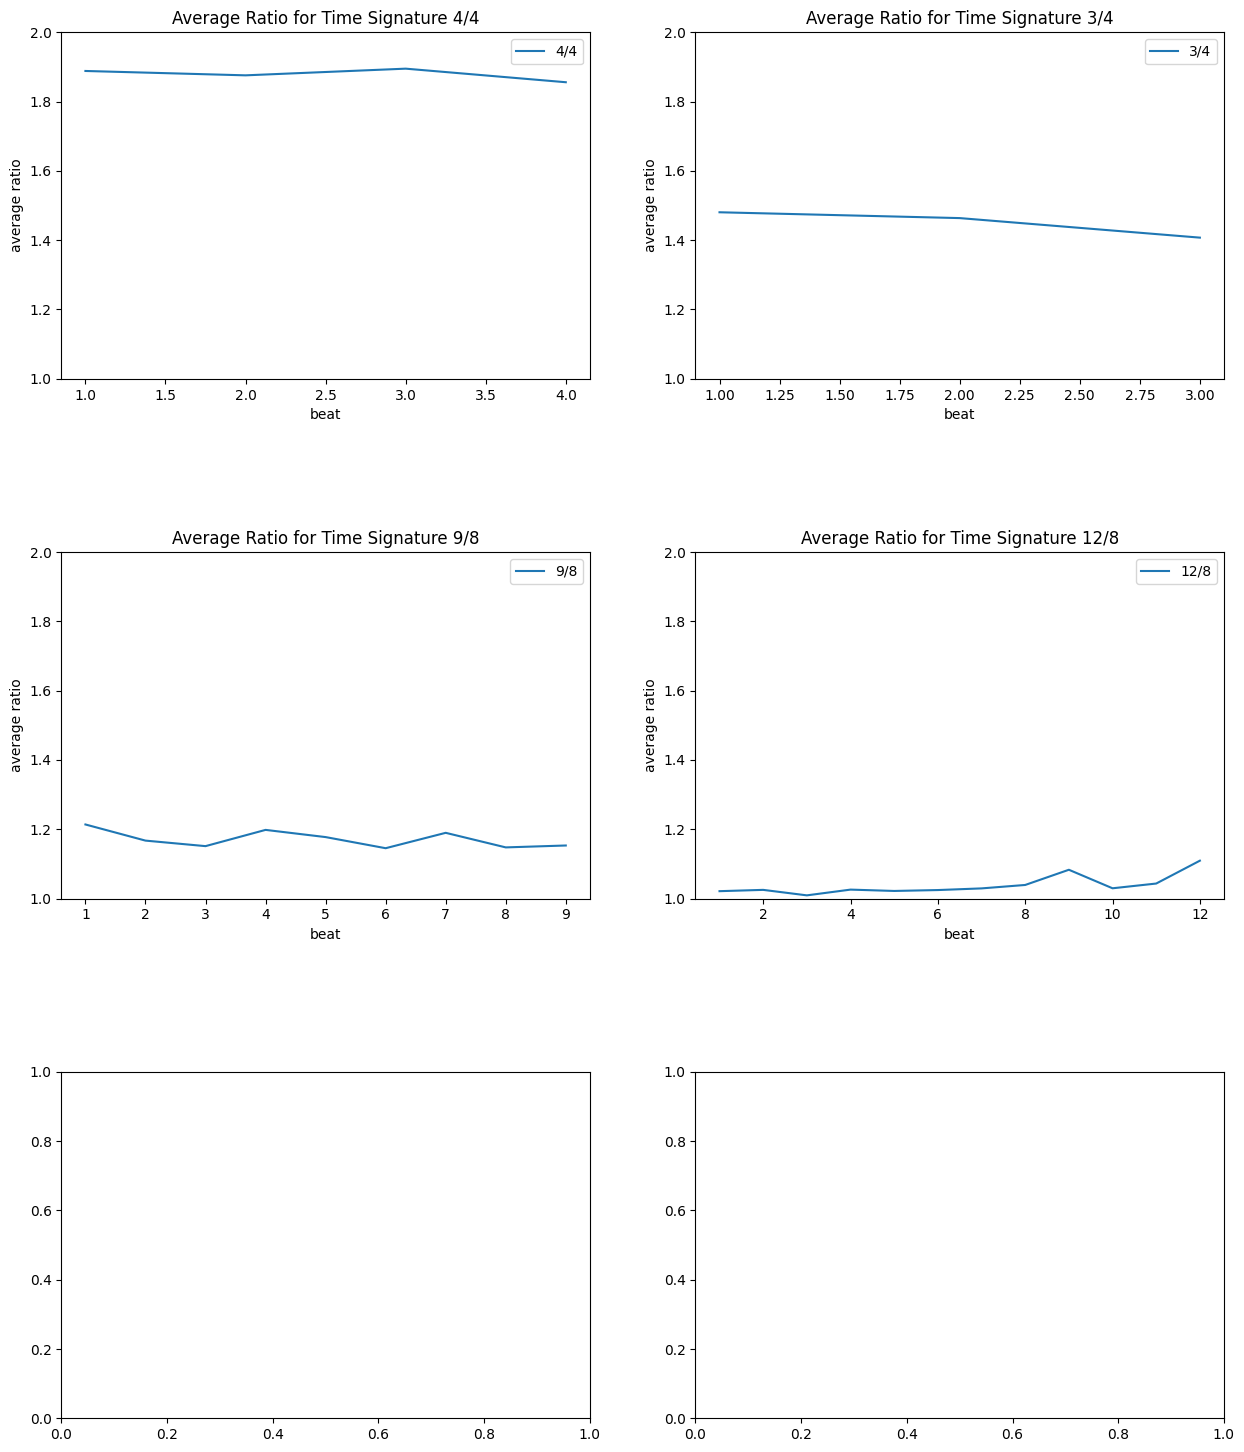

In [209]:
# with y limit from 1.0 to 2.0
plot_group_means(path)

Plotting the grouped means of three segments


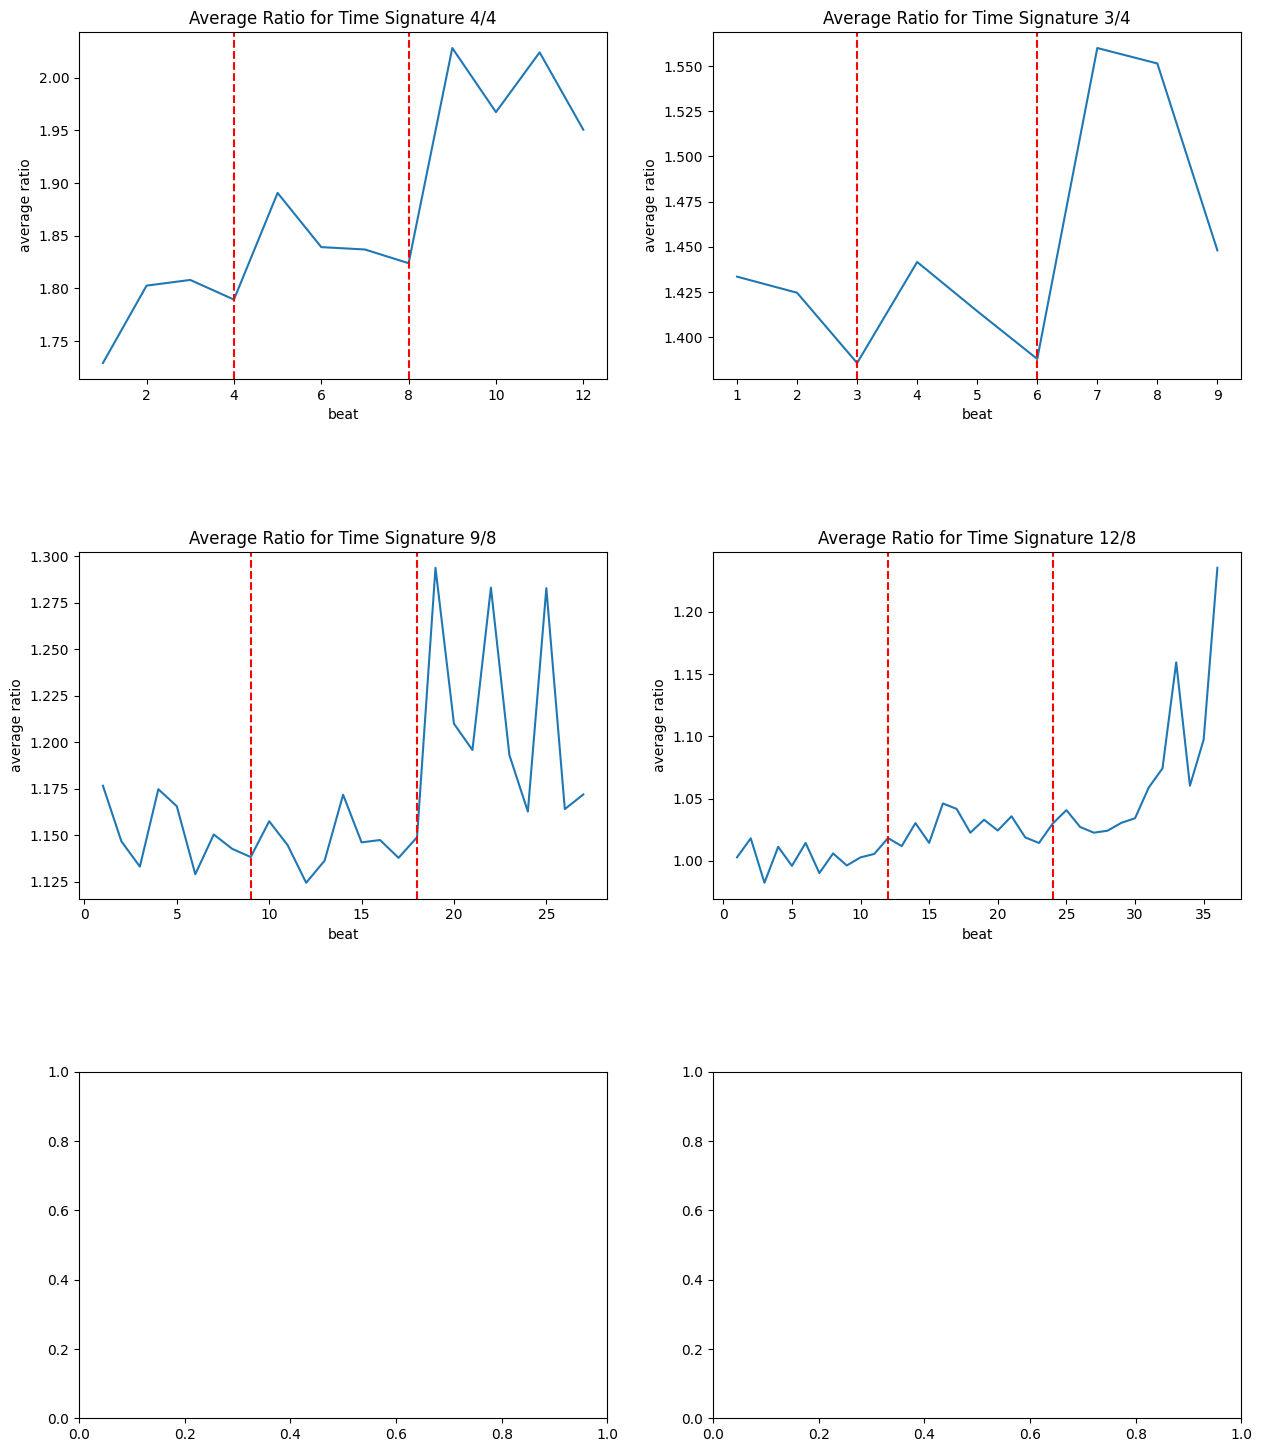

In [211]:
# y not limited
plot_three_segment_group_means(path)

Plotting the grouped means of three segments


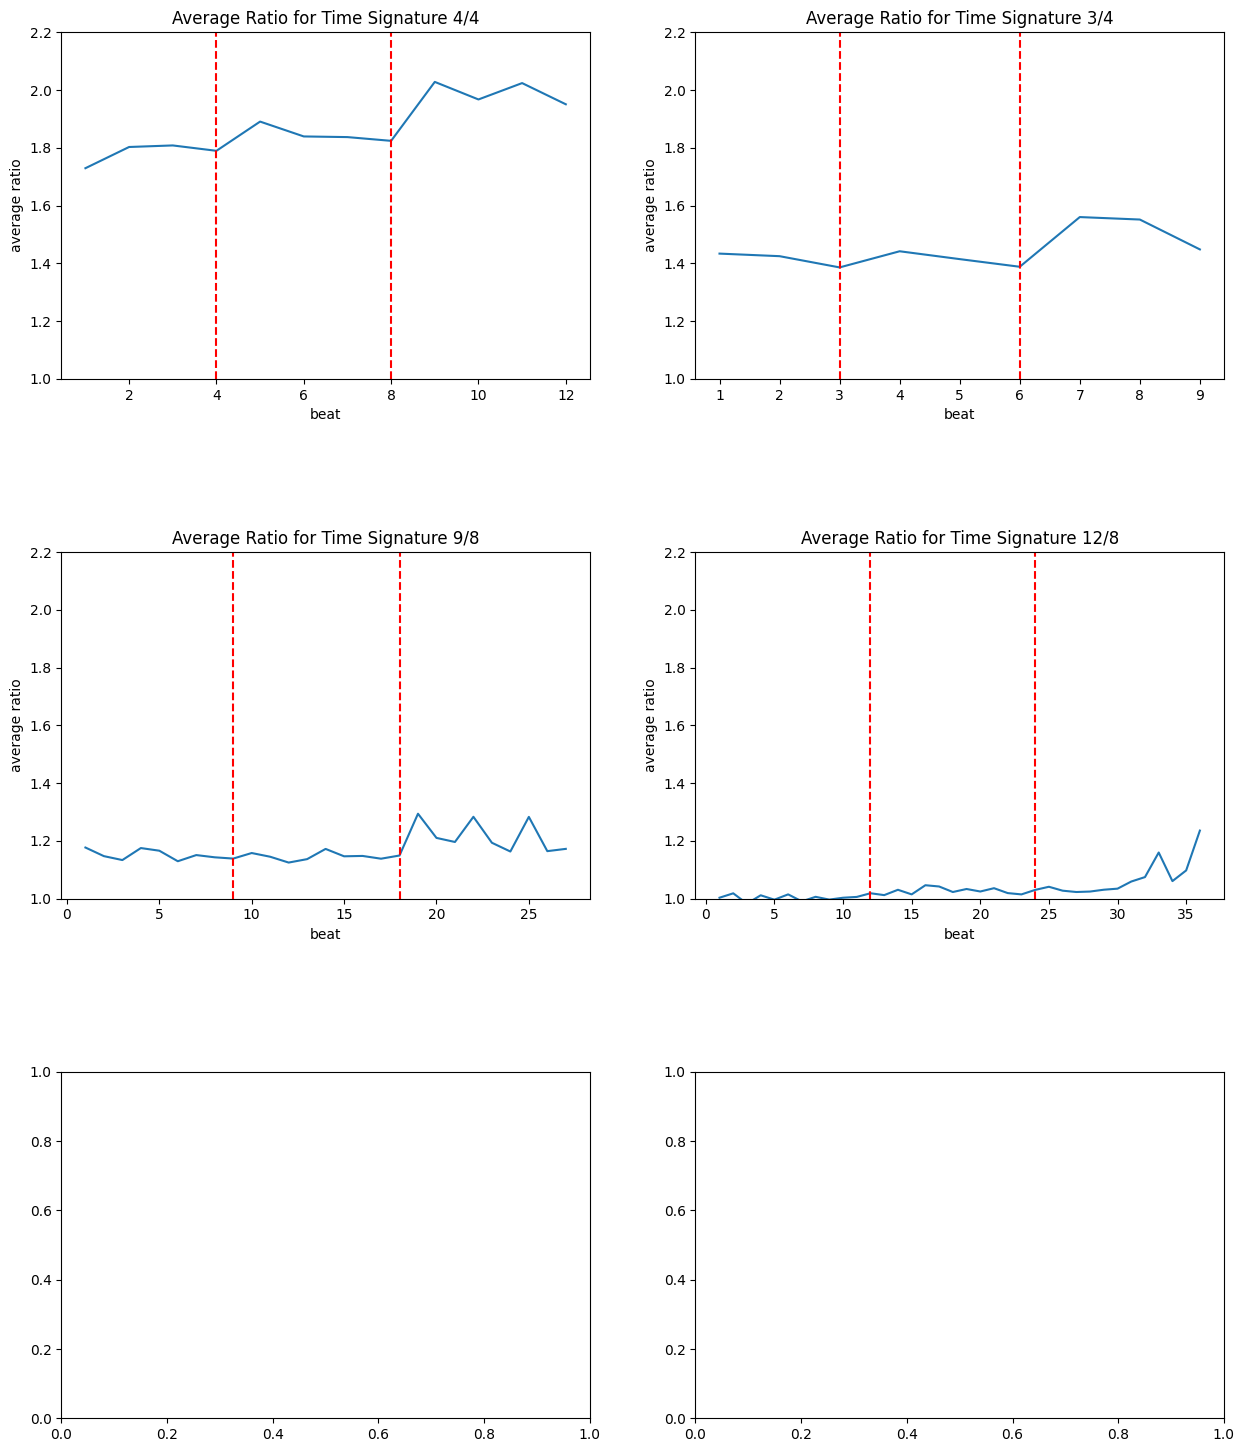

In [203]:
# y limited to 1.0 to 2.2
plot_three_segment_group_means(path)